# 分类问题评估模型的性能并调参:                        
更详细的阅读知乎：https://zhuanlan.zhihu.com/p/140040705

In [1]:
# 加载数据
import pandas as pd
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data",header=None)
# 做基本的数据预处理
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:,2:].values
y = df.iloc[:,1].values
le = LabelEncoder()    #将M-B等字符串编码成计算机能识别的0-1
y = le.fit_transform(y)
le.transform(['M','B'])
# 数据切分8：2
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)

In [2]:
# 使用网格搜索进行超参数调优：
# 方式1：网格搜索GridSearchCV()
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

import time

start_time = time.time()
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [{'svc__C':param_range,'svc__kernel':['linear']},{'svc__C':param_range,'svc__gamma':param_range,'svc__kernel':['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring='accuracy',cv=10,n_jobs=-1)
gs = gs.fit(X,y)
end_time = time.time()
print("网格搜索经历时间：%.3f S" % float(end_time-start_time))
print(gs.best_score_)
print(gs.best_params_)

网格搜索经历时间：5.003 S
0.9789103690685413
{'svc__C': 0.1, 'svc__kernel': 'linear'}


/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [3]:
# 方式2：随机网格搜索RandomizedSearchCV()
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import time

start_time = time.time()
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = {
        'svc__C':param_range,
        'svc__kernel':['linear'],
        'svc__C':param_range,
        'svc__gamma':param_range,
        'svc__kernel':['rbf']
    }
# param_grid = [{'svc__C':param_range,'svc__kernel':['linear','rbf'],'svc__gamma':param_range}]
gs = RandomizedSearchCV(estimator=pipe_svc, param_distributions=param_grid,scoring='accuracy',cv=10,n_jobs=-1)
gs = gs.fit(X,y)
end_time = time.time()
print("随机网格搜索经历时间：%.3f S" % float(end_time-start_time))
print(gs.best_score_)
print(gs.best_params_)


随机网格搜索经历时间：0.456 S
0.9718804920913884
{'svc__kernel': 'rbf', 'svc__gamma': 0.0001, 'svc__C': 100.0}


**当类别为两类时，可以绘制混淆矩阵与ROC曲线**

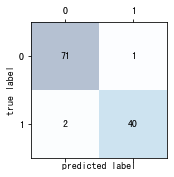

In [4]:
# 混淆矩阵：
# 加载数据
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data",header=None)
'''
乳腺癌数据集：569个恶性和良性肿瘤细胞的样本，M为恶性，B为良性
'''
# 做基本的数据预处理
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

X = df.iloc[:,2:].values
y = df.iloc[:,1].values
le = LabelEncoder()    #将M-B等字符串编码成计算机能识别的0-1
y = le.fit_transform(y)
le.transform(['M','B'])
# 数据切分8：2
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)
from sklearn.svm import SVC
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train,y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test,y_pred=y_pred)
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat, cmap=plt.cm.Blues,alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],va='center',ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

<Figure size 432x288 with 0 Axes>

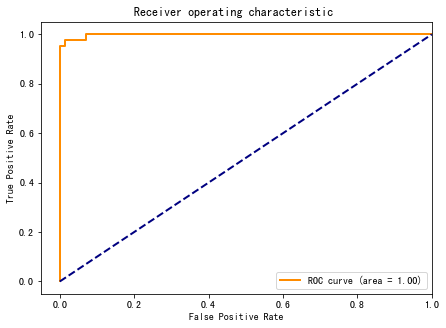

In [5]:
# 绘制ROC曲线：
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import make_scorer,f1_score
scorer = make_scorer(f1_score,pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring=scorer,cv=10)
y_pred = gs.fit(X_train,y_train).decision_function(X_test)
#y_pred = gs.predict(X_test)
fpr,tpr,threshold = roc_curve(y_test, y_pred) ###计算真阳率和假阳率
roc_auc = auc(fpr,tpr) ###计算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假阳率为横坐标，真阳率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.show()


# 3.结语

本章中，我们重点讨论了各种回归和分类算法的具体推导与简单应用，并且给出了如何使用sklearn这个强大的python工具库进行简单的机器学习模型的建模代码。本章的重点是各个基础算法的掌握，包括回归和分类(重点是分类)算法以及怎么用网格搜索以及其他搜索方式进行调参。简单模型在进行复杂项目的时候往往显得力不从心，那么在下一章中，我们将开始本次开源项目的主题----集成学习，我们着重讨论如何将本章所学的基础模型进行集成，变成功能更加强大的集成模型。

为了巩固本章的理解，在这里给个小任务，大家结合sklearn的fetch_lfw_people数据集，进行一次实战。fetch_lfw_people数据集是一个图像数据集，详细内容可以参照：                   
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html                   
案例的内容是对图像进行识别并分类。               
参考资料：                
https://blog.csdn.net/cwlseu/article/details/52356665                      
https://blog.csdn.net/jasonzhoujx/article/details/81905923

/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/U

/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/wangyanan/opt/miniconda3/lib/py

/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/wangyanan/opt/miniconda3/lib/py

/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/wangyanan/opt/miniconda3/lib/py

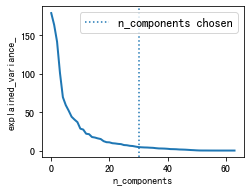

In [6]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline

logistic = linear_model.LogisticRegression()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

# Plot the PCA spectrum
pca.fit(X_digits)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

# Prediction

n_components = [10, 20, 25, 30, 35, 40, 50, 64]#[i for i in range(1,65)]#
Cs = np.logspace(-4, 4, 3)

estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(X_digits, y_digits)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()



/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt

/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt

/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt

/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt

/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt

/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/_pilutil.py:416: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()
/Users/wangyanan/opt

/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Total dataset size:
n_samples: 639
n_features: 1850
n_classes: 2
Extracting the top 80 eigenfaces from 479 faces
done in 0.036s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.004s
Fitting the classifier to the training set


/Users/wangyanan/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


done in 2.503s
Best estimator found by grid search:
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
[213  72]
Predicting people's names on the test set
done in 0.004s
                   precision    recall  f1-score   support

    George W Bush       0.98      0.94      0.96       138
Gerhard Schroeder       0.71      0.91      0.80        22

        micro avg       0.94      0.94      0.94       160
        macro avg       0.85      0.93      0.88       160
     weighted avg       0.95      0.94      0.94       160

[[130   8]
 [  2  20]]


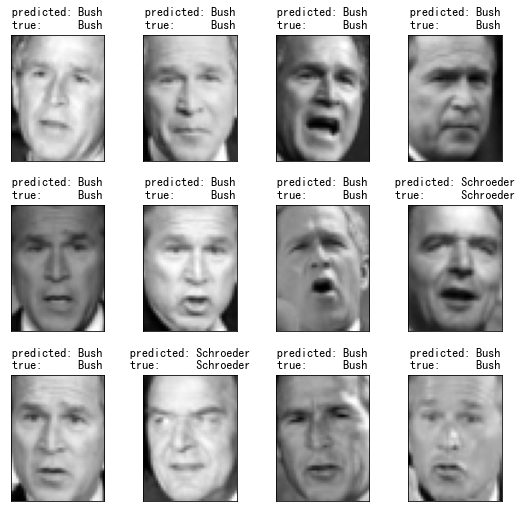

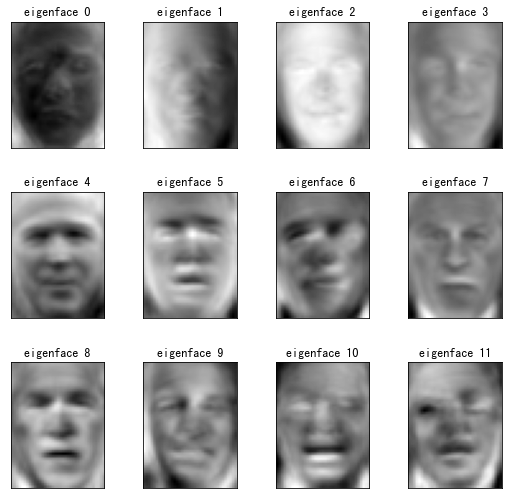

In [7]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


###############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 80

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


###############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1,10, 100, 500, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

print(clf.best_estimator_.n_support_)
###############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        # Show the feature face
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

